## Load Libs

In [1]:
import os
src_path = os.getcwd()
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
from PIL import Image
import re
import textwrap

#Load models libs
from models.blip import blip_decoder
from sentence_transformers import SentenceTransformer
from diffusers import StableDiffusionPipeline
torch.__version__

'2.5.0+cu124'

In [2]:
cudnn.benchmark = False 
cudnn.deterministic = True 
torch.set_num_threads(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cudnn.benchmark = False 
cudnn.deterministic = True 
torch.set_num_threads(1)
#random.seed(seed) 
image_size = 384

## SalesForce BLIP Image Caption Generator

In [4]:
model = blip_decoder(pretrained=False, image_size=image_size, vit='base')
weights_path = src_path + r'/weights/blip/pretrained_blip384.pth'
model.load_state_dict(torch.load(weights_path))
model.eval()
#model = model.to(device)
print('The BLIP Decoder is loaded successfully')

BertLMHeadModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


The BLIP Decoder is loaded successfully


In [5]:
## clean text from punctuations and non alphabetic chars
def clean_text(caption,max_words=20):
    caption = re.sub(
        r"([.!\"()*#:;~])",
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n')
    caption = caption.strip(' ')
    #truncate caption
    caption_words = caption.split(' ')
    if len(caption_words)>max_words:
        caption = ' '.join(caption_words[:max_words])
    return caption

## Latent Diffusion Model: text to image generator

In [6]:
#model_id = "segmind/tiny-sd"
#model_id = "stabilityai/stable-diffusion-2-base"
# Use the Euler scheduler here instead
#scheduler = EulerDiscreteScheduler.from_pretrained(src_path+ r'/weights/scheduler') #.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(src_path + r'/weights/base2_sd')
#pipe = pipe.to(device)
print('The Distilled Small Stable Difusion is loaded successfully')

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The Distilled Small Stable Difusion is loaded successfully


In [7]:
### text to image generation function 
def generate_image(prompt, num_images=1, seed=42):    
    with torch.no_grad(): 
        image = pipe(
            prompt,
            #negative_prompt = "",
            height = 384,
            width = 384, 
            num_images_per_prompt=1,
            num_inference_steps=20, 
            #guidance_scale=8,
            generator= torch.Generator('cuda').manual_seed(seed),
        ).images[0] 
    return image

pipe.set_progress_bar_config(disable=True)

#hannah.reber@karrieretutor.de

In [22]:
mean = torch.tensor( [0.485,0.456,0.406])# [0.5277, 0.4688, 0.4613])
std = torch.tensor( [0.2966, 0.2814, 0.2517])   
process = transforms.Compose([
        transforms.Resize((384, 384)),  
        transforms.ToTensor(), 
        transforms.Normalize(mean, std)
        ])

In [9]:
def display(image):
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

## Compute Similarities

#### Sentence Transformer

In [10]:
### Sentence Transformer all-MiniLM-L6-v2
similaritytransformer = SentenceTransformer(src_path + r'/weights/sentence_transformers') 
#('sentence-transformers/all-MiniLM-L6-v2')
similaritytransformer = similaritytransformer.eval().to(device)
print("sentence transformer is loaded successfully")

sentence transformer is loaded successfully


In [11]:
def compute_prompt_caption_similarity(prompt, caption):
    embeddings1 = similaritytransformer.encode(prompt, convert_to_tensor=True).unsqueeze(0)
    embeddings2 = similaritytransformer.encode(caption, convert_to_tensor=True).unsqueeze(0)
    similarity = torch.nn.functional.cosine_similarity(embeddings1, embeddings2)    
    del embeddings1, embeddings2
    return similarity.item()

#### Resnet18

In [12]:
resnet = models.resnet18(pretrained=True)
resnet.eval()
resnet.fc = torch.nn.Identity()
print("Resnet modle is loaded")

Resnet modle is loaded


In [13]:
def compare_images(image1, image2):
    # Preprocess the images
    image_tensor1 = process(image1).unsqueeze(0)
    image_tensor2 = process(image2).unsqueeze(0)

    # Forward pass to obtain features
    with torch.no_grad():
        features1 = resnet(image_tensor1)
        features2 = resnet(image_tensor2)

    # Compute cosine similarity between the features
    cos_sim = torch.nn.functional.cosine_similarity(features1, features2)
    del features1, features2
    return cos_sim.item()

## Main: Pipeline

In [14]:
def recreate_image(model, pipe, image, prompt):
    print('Original Input')
    print(textwrap.fill('Prompt: ' + prompt, width=50))
    display(image)
    sq_image = process(image).unsqueeze(0)

    print('Generated Output')
    model = model.to(device)
    torch.manual_seed(seed)
    caption = model.generate(sq_image.to(device), sample=True, top_p=0.8, max_length=20, min_length=15)[0]
    caption = "photo of " + clean_text(caption, 50)
    model = model.to('cpu')
    print(textwrap.fill('Generated Caption: ' + caption, width=50))

    pipe = pipe.to(device)
    generated_image = generate_image(prompt= caption)
    pipe = pipe.to('cpu')
    display(generated_image)
    
    print('Validation Measures')
    text_similarity_score = compute_prompt_caption_similarity(prompt,caption )
    print("the Prompt Caption Similarity Score: ", text_similarity_score)
    image_similarity_score = compare_images(image, generated_image)
    print("Images Caption Similarity Score: ", image_similarity_score)

    del image, sq_image, generated_image, caption

## Main: examples

Original Input
Prompt: photo of an italian man, beanie, winter
outfit, white nike sneakers, standing on a path,
snowy winter day in the countryside, pastel green
and brown colors


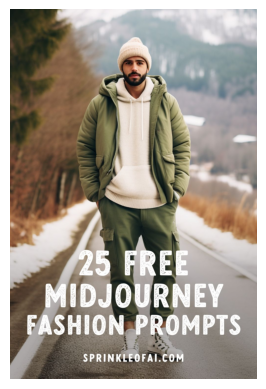

Generated Output
Generated Caption: photo of a man wearing an army
green jacket, white shirt and beanie hat standing
on


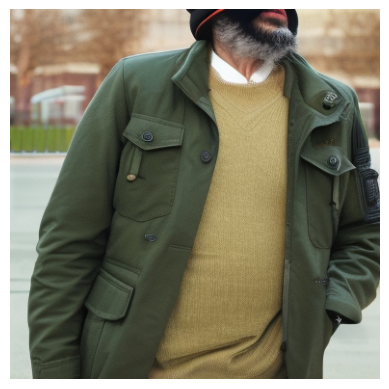

Validation Measures
the Prompt Caption Similarity Score:  0.520976722240448
Images Caption Similarity Score:  0.7703746557235718


In [58]:
prompt = "photo of an Italian man, beanie, winter outfit, white nike sneakers, standing on a path, snowy winter day in the countryside, pastel green and brown colors"
prompt = clean_text(prompt, 50)
image_name = 'italian'
image = Image.open(src_path+ r'/images/{}.png'.format(image_name))
recreate_image(model, pipe, image, prompt)

Prompt: photo of an italian man, beanie, winter
outfit, white nike sneakers, standing on a path,
snowy winter day in the countryside, pastel green
and brown colors


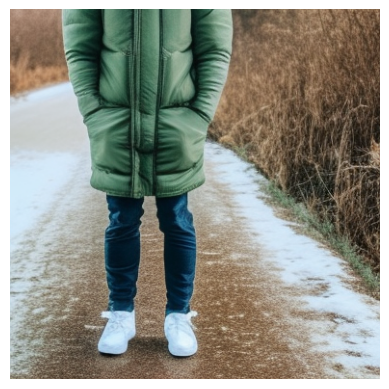

In [28]:
prompt = "photo of an Italian man, beanie, winter outfit, white nike sneakers, standing on a path, snowy winter day in the countryside, pastel green and brown colors"
prompt = clean_text(prompt, 50)
print(textwrap.fill('Prompt: ' + prompt, width=50))
pipe = pipe.to(device)
generated_image = generate_image(prompt= prompt)
pipe = pipe.to('cpu')
display(generated_image)
del generated_image, prompt

In [26]:
import pandas as pd
test_df = pd.read_csv(src_path+ r'/output/eval/output.csv')

def read_text_image_pair(id):
    image_path = src_path+ r'/output/eval/test_images/{}.png'.format(id)
    image = Image.open(image_path)
    prompt = test_df.iloc[id]['prompt']
    return image, prompt

Original Input
Prompt: black sports shoes for man nike man's zoom
vomero black shoe


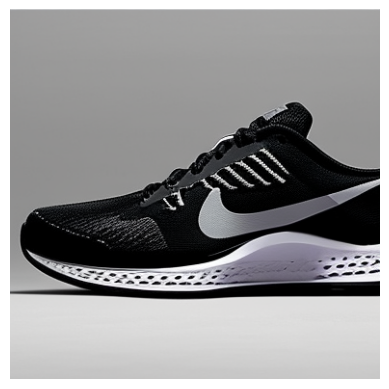

Generated Output
Generated Caption: photo of the nike lunar trainer
running shoe in black and white for women


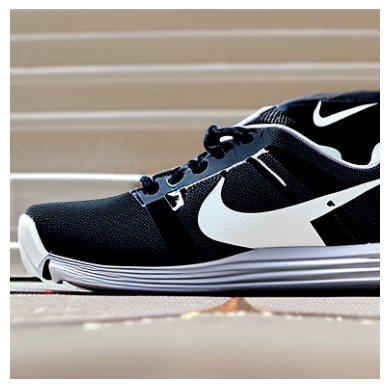

Validation Measures
the Prompt Caption Similarity Score:  0.5502030849456787
Images Caption Similarity Score:  0.8790950179100037


In [27]:
image, prompt = read_text_image_pair(42)
recreate_image(model, pipe, image, prompt)

Original Input
Prompt: a dress of black and red stripes in red
and blue, in the style of surrealistic poses
spirals, national geographic photo, dark orange
and light bronze, ayami kojima, flowing lines,
mark henson


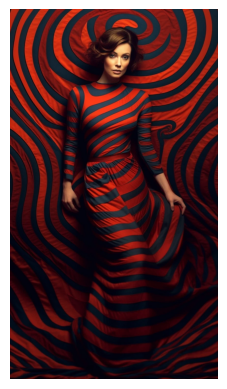

Generated Output
Generated Caption: photo of a woman wearing red,
black and orange dress in the center of a swirling
vortex


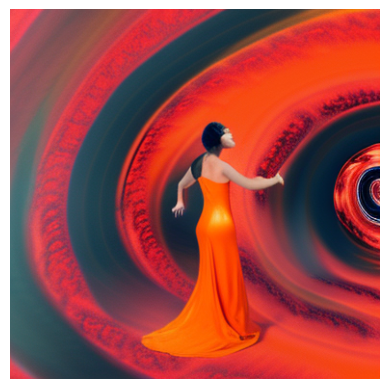

Validation Measures
the Prompt Caption Similarity Score:  0.5365437269210815
Images Caption Similarity Score:  0.7354552149772644


In [23]:
prompt = "a dress of black and red stripes in red and blue, in the style of surrealistic poses spirals, national geographic photo, dark orange and light bronze, ayami kojima, flowing lines, mark henson"
prompt = clean_text(prompt, 100)
image_name = 'red'
image = Image.open(src_path+ r'/images/{}.png'.format(image_name))
recreate_image(model, pipe, image, prompt)

Prompt: a dress of black and red stripes in red
and blue, in the style of surrealistic poses
spirals, national geographic photo, dark orange
and light bronze, ayami kojima, flowing lines,
mark henson


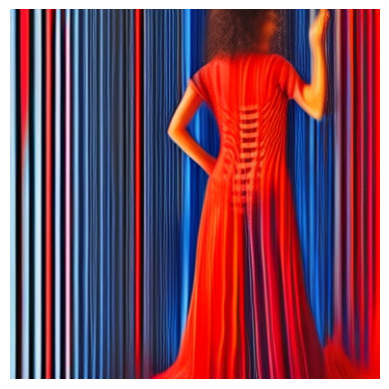

In [29]:
prompt = "a dress of black and red stripes in red and blue, in the style of surrealistic poses spirals, national geographic photo, dark orange and light bronze, ayami kojima, flowing lines, mark henson"
prompt = clean_text(prompt, 100)
print(textwrap.fill('Prompt: ' + prompt, width=50))
pipe = pipe.to(device)
generated_image = generate_image(prompt= prompt)
pipe = pipe.to('cpu')
display(generated_image)
del generated_image, prompt